# Lab assignment: analyzing the Titanic with decision trees

<img src="img/titanic.jpg" style="width:640px;height:406px;">

In this assignment we will learn how to use decision trees for classification problems. In particular, we will make use of the reference implementation in scikit-learn, and we will seek explainability on the historic accident of the Titanic.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">You will need to solve a question by writing your own code or answer in the cell immediately below, or in a different file as instructed. Both correctness of the solution and code quality will be taken into account for marking.</td></tr>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">This is a hint or useful observation that can help you solve this assignment. You are not expected to write any solution, but you should pay attention to them to understand the assignment.</td></tr>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">This is an advanced and voluntary excercise that can help you gain a deeper knowledge into the topic. This exercise won't be taken into account towards marking, but you are encouraged to undertake it. Good luck!</td></tr>
</table>

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Ensembles environment files](https://github.com/albarji/teaching-environments-ensembles).

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Shift+Tab to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Preliminaries

First of all, let's fix a random seed so all results are reproducible in different runs of the notebook.

In [1]:
import numpy as np
np.random.seed(12345)

The following code will embed any plots into the notebook instead of generating a new window:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Data preparation

For this assignment we will use the **titanic** dataset. This dataset is made of information about the passengers of the famous Titanic ship, and whether they where lucky enough to survive its tragedy or not. We will use these data for building a decision tree that will be able to predict the survival of a Titanic passenger.

### Data loading

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 The titanic data is contained in the file <b>titanic.csv</b>. Take a look at the file format, and write the appropriate code to load all of it into a Pandas DataFrame named <b>data</b>.
 </td></tr>
</table>

In [3]:
####### INSERT YOUR CODE HERE
import pandas as pd
data = pd.read_csv("titanic.csv", sep=',')

If you have loaded the data properly, the following cell should output a table with the first 5 rows of the data:

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Selecting features

Some of the features included in the dataset are of no relevance for the survival probability. For instance, the **PassengerId** is just a unique identifier that does not provide of meaningful information about the passenger; thus we would be better off removing it. The same happens with the **Ticket** number. We will also remove the **Name**: although the surname might me useful for identifying relatives aboard the ship, for simplicity we will ignore this feature. Finally, the **Cabin** will also be removed, as it has too many possible values and will introduce too much noise in the model.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create a new DataFrame <b>selecteddata</b> as a copy of the original DataFrame but where the PassengerId, Ticket and Name columns have been removed.
 </td></tr>
</table>

 <table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">The <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html">drop</a> method from a Pandas Dataframe might help you</td></tr>

In [5]:
####### INSERT YOUR CODE HERE
selecteddata = data.drop(["PassengerId", "Ticket", "Name", "Cabin"], axis=1)

If correctly done, the following should show the first 5 rows of data without neither the removed columns.

In [6]:
selecteddata.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Codifying categorical features

The Decision Trees of scikit-learn only accept numerical features. Hence, columns such as **Sex** and **Embarked** should be recoded using a numerical format. We will make use of the <a href=http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html>**get_dummies**</a> method from pandas to do so:

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create a new DataFrame <b>numericaldata</b> with the data after the application of the get_dummies method.
 </td></tr>
</table>

In [7]:
####### INSERT YOUR CODE HERE
numericaldata = pd.get_dummies(selecteddata, columns=["Sex", "Embarked"])

We should now see that the original columns have been replaced by dummy one-hot-encoded columns:

In [8]:
numericaldata.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


### Missing values imputation

The dataset is full of missing values, so we will need to address those before moving on. For categorical features the get_dummies procedure above already takes care of the missing values, by means of setting all dummies to zero whenever a missing value is found. But for the remaining numerical features we will need to apply an imputation method explicitly.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Create a new DataFrame <b>imputeddata</b> with a version of the data above where the missing values have been replaced by the mean value of their column.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td>
     The <b>fillna</b> and <b>mean</b> functions from a DataFrame object can help you in this task.
 </td></tr>
</table>

In [9]:
####### INSERT YOUR CODE HERE
imputeddata = numericaldata.fillna(numericaldata.mean())

If done correctly, we should have zero NaN values over the whole DataFrame:

In [10]:
assert(imputeddata.isnull().sum().sum() == 0)

### Extracting the target

Let's now extract the column that represents the class we want to predict (*Survived*).

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Create DataFrames X, Y. The X DataFrame should contain only the explanatory variables, while the Y DataFrame must contain only the target variable <b>Survived</b>.
 </td></tr>
</table>

In [11]:
####### INSERT YOUR CODE HERE
X, Y = imputeddata.drop(["Survived"], axis=1), imputeddata["Survived"]

Let's check we have done this correctly:

In [12]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [13]:
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

### Splitting the data

In what follows we will use a training/test splitting of the data. We will perform that splitting now, making use of the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">train_test_split</a> function.

In [14]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33, stratify=Y)

With the call above, we have splitted the inputs `X` and outputs `Y` into two datasets, `(Xtrain, Ytrain)` and `(Xtest, Ytest)`. The `test_size` parameter specifies that a third of the data will be used as the test set. The `stratify` parameter is also relevant: it ensures that the same proportion of surviving and deceased passengers are present in both train and test datasets, by following the class values present in `Y`.

Let's check that:

In [15]:
Xtrain.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
662,1,47.000000,0,0,25.5875,0,1,0,0,1
889,1,26.000000,0,0,30.0000,0,1,1,0,0
633,1,29.699118,0,0,0.0000,0,1,0,0,1
492,1,55.000000,0,0,30.5000,0,1,0,0,1
667,3,29.699118,0,0,7.7750,0,1,0,0,1


In [16]:
Ytrain.head()

662    0
889    1
633    0
492    0
667    0
Name: Survived, dtype: int64

In [17]:
Xtest.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
525,3,40.5,0,0,7.750,0,1,0,1,0
346,2,40.0,0,0,13.000,1,0,0,0,1
131,3,20.0,0,0,7.050,0,1,0,0,1
311,1,18.0,2,2,262.375,1,0,1,0,0
429,3,32.0,0,0,8.050,0,1,0,0,1


In [18]:
Ytest.head()

525    0
346    1
131    0
311    1
429    1
Name: Survived, dtype: int64

## How to create a decision tree

In scikit-learn, the machine learning library for Python, a Decision Tree for classification can be created through the DecisionTreeClassifier class:

In [19]:
from sklearn.tree import DecisionTreeClassifier

For now let's create a simple Decision Tree letting scikit-learn choose all the model parameters:

In [20]:
decisiontree = DecisionTreeClassifier()

Once the tree is created, we can now train it on our training data, using the function **fit**. But let us first create a toy dataset to show how the whole procedure works, before using the Titanic data we prepared above.

In [21]:
Xtoy = pd.DataFrame(data=[[0, 0], [1, 1]], columns=["Number of Jumbos", "Procrastination ratio"])
ytoy = pd.DataFrame(data=[0, 1], columns=["Class"])
display(Xtoy)
display(ytoy)

,Number of Jumbos,Procrastination ratio
0,0,0
1,1,1


,Class
0,0
1,1


Now let's fit the tree to this toy data:

In [22]:
decisiontree.fit(Xtoy, ytoy)

DecisionTreeClassifier()

We can analyze the details of the model parameters with the following

In [23]:
decisiontree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In particular, we can see that the **Gini** splitting criterion is being used.

Also, using the `classes_` attribute we can check the identifiers of classes this tree can predict. We will come back to this in a while when visualizing the tree structure.

In [24]:
decisiontree.classes_

array([0, 1], dtype=int64)

Once the tree is trained we can use it to generate predictions over data. Reusing the same toy data:

In [25]:
decisiontree.predict(Xtoy)

array([0, 1], dtype=int64)

If we compare these predictions agains the ytoy labels we can see that the tree has been able to correctly predict the class labels for the data. We can also compute a **score** for the tree based on the performance over these data:

In [26]:
decisiontree.score(Xtoy, ytoy)

1.0

For classification models of scikit-learn (such as this tree) the score method returns the accuracy, that is, the fraction of the test data the classifier can label correctly. We obtain a 100% acccuracy! Not such a remarkable feat though, if we take into account we are predicting for a toy dataset, which furthermore was also used for training. But it has served us to portray the basic functions of a Decision Tree.

To further analyze the workings of the tree we can create a visualization of it. Note we can provide the visualization function with the names of the features and the classes to obtain a more understandable representation. The class names must be provided as a list with one name per class, and they should follow the order of the classes in the `classes_` attribute we printed a few cells above. We can also configure the size of the plot using the *figsize* parameters we provide to the **plt.figure** function.

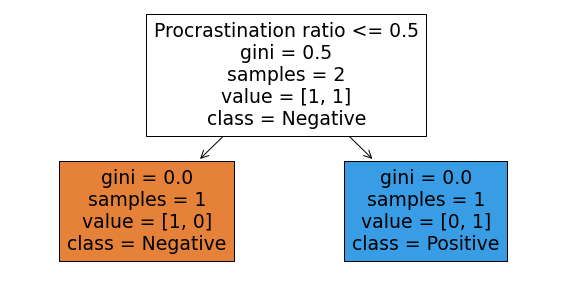

In [27]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,5))
plot_tree(
    decisiontree,  # The tree we want to plot
    feature_names=Xtoy.columns,  # Take the feature names from the column names in the data
    class_names=["Negative", "Positive"],  # 0="Negative", 1="Positive"
    filled=True
)
plt.show()

We can see that the tree is made up of a root node, where the split is made in one of the variables at value 0.5. The child node at the left side contains all data points that answer **yes** to the question used for splitting, while the right-side child contains all data points that answer **no** to that question. Before this split the Gini impurity is 0.5, as we have one pattern from each class. After the split we obtain two leaf nodes with 0 impurity, each of them containing a single pattern from either class. 

It is also possible to obtain a text-based explanation of the tree using the **export_text** function. This can become handy when analyzing very large trees.

In [28]:
from sklearn.tree import export_text

print(export_text(decisiontree, feature_names=list(Xtoy.columns)))

|--- Procrastination ratio <= 0.50
|   |--- class: 0
|--- Procrastination ratio >  0.50
|   |--- class: 1



## Analyzing the Titanic (and why Leonardo DiCaprio [SPOILER])

We will now make use of a Decision Tree to obtain a classifier of survivors of the Titanic, and also to learn something about the kind of people who survived.

### Creating a Titanic Tree

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Create a new Decision Tree named <b>titanictree</b> and use the training subset you prepared above to fit this tree. Use the default tree parameters.
 </td></tr>
</table>

In [29]:
####### INSERT YOUR CODE HERE
titanictree = DecisionTreeClassifier()
titanictree.fit(Xtrain, Ytrain)

DecisionTreeClassifier()

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Now create a plot of the tree, replicating the steps above. Can you spot anything interesting? Do you think this representation of the model is intuitive?
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Take a look at the dataset README.md to check which class corresponds to Deceased and which to Survived, and also check the classes_ attribute in the fitted tree to assign names properly.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Is the plot too small to read? Try increasing the figsize values and double-click in the plot to zoom in.
 </td></tr>
</table>

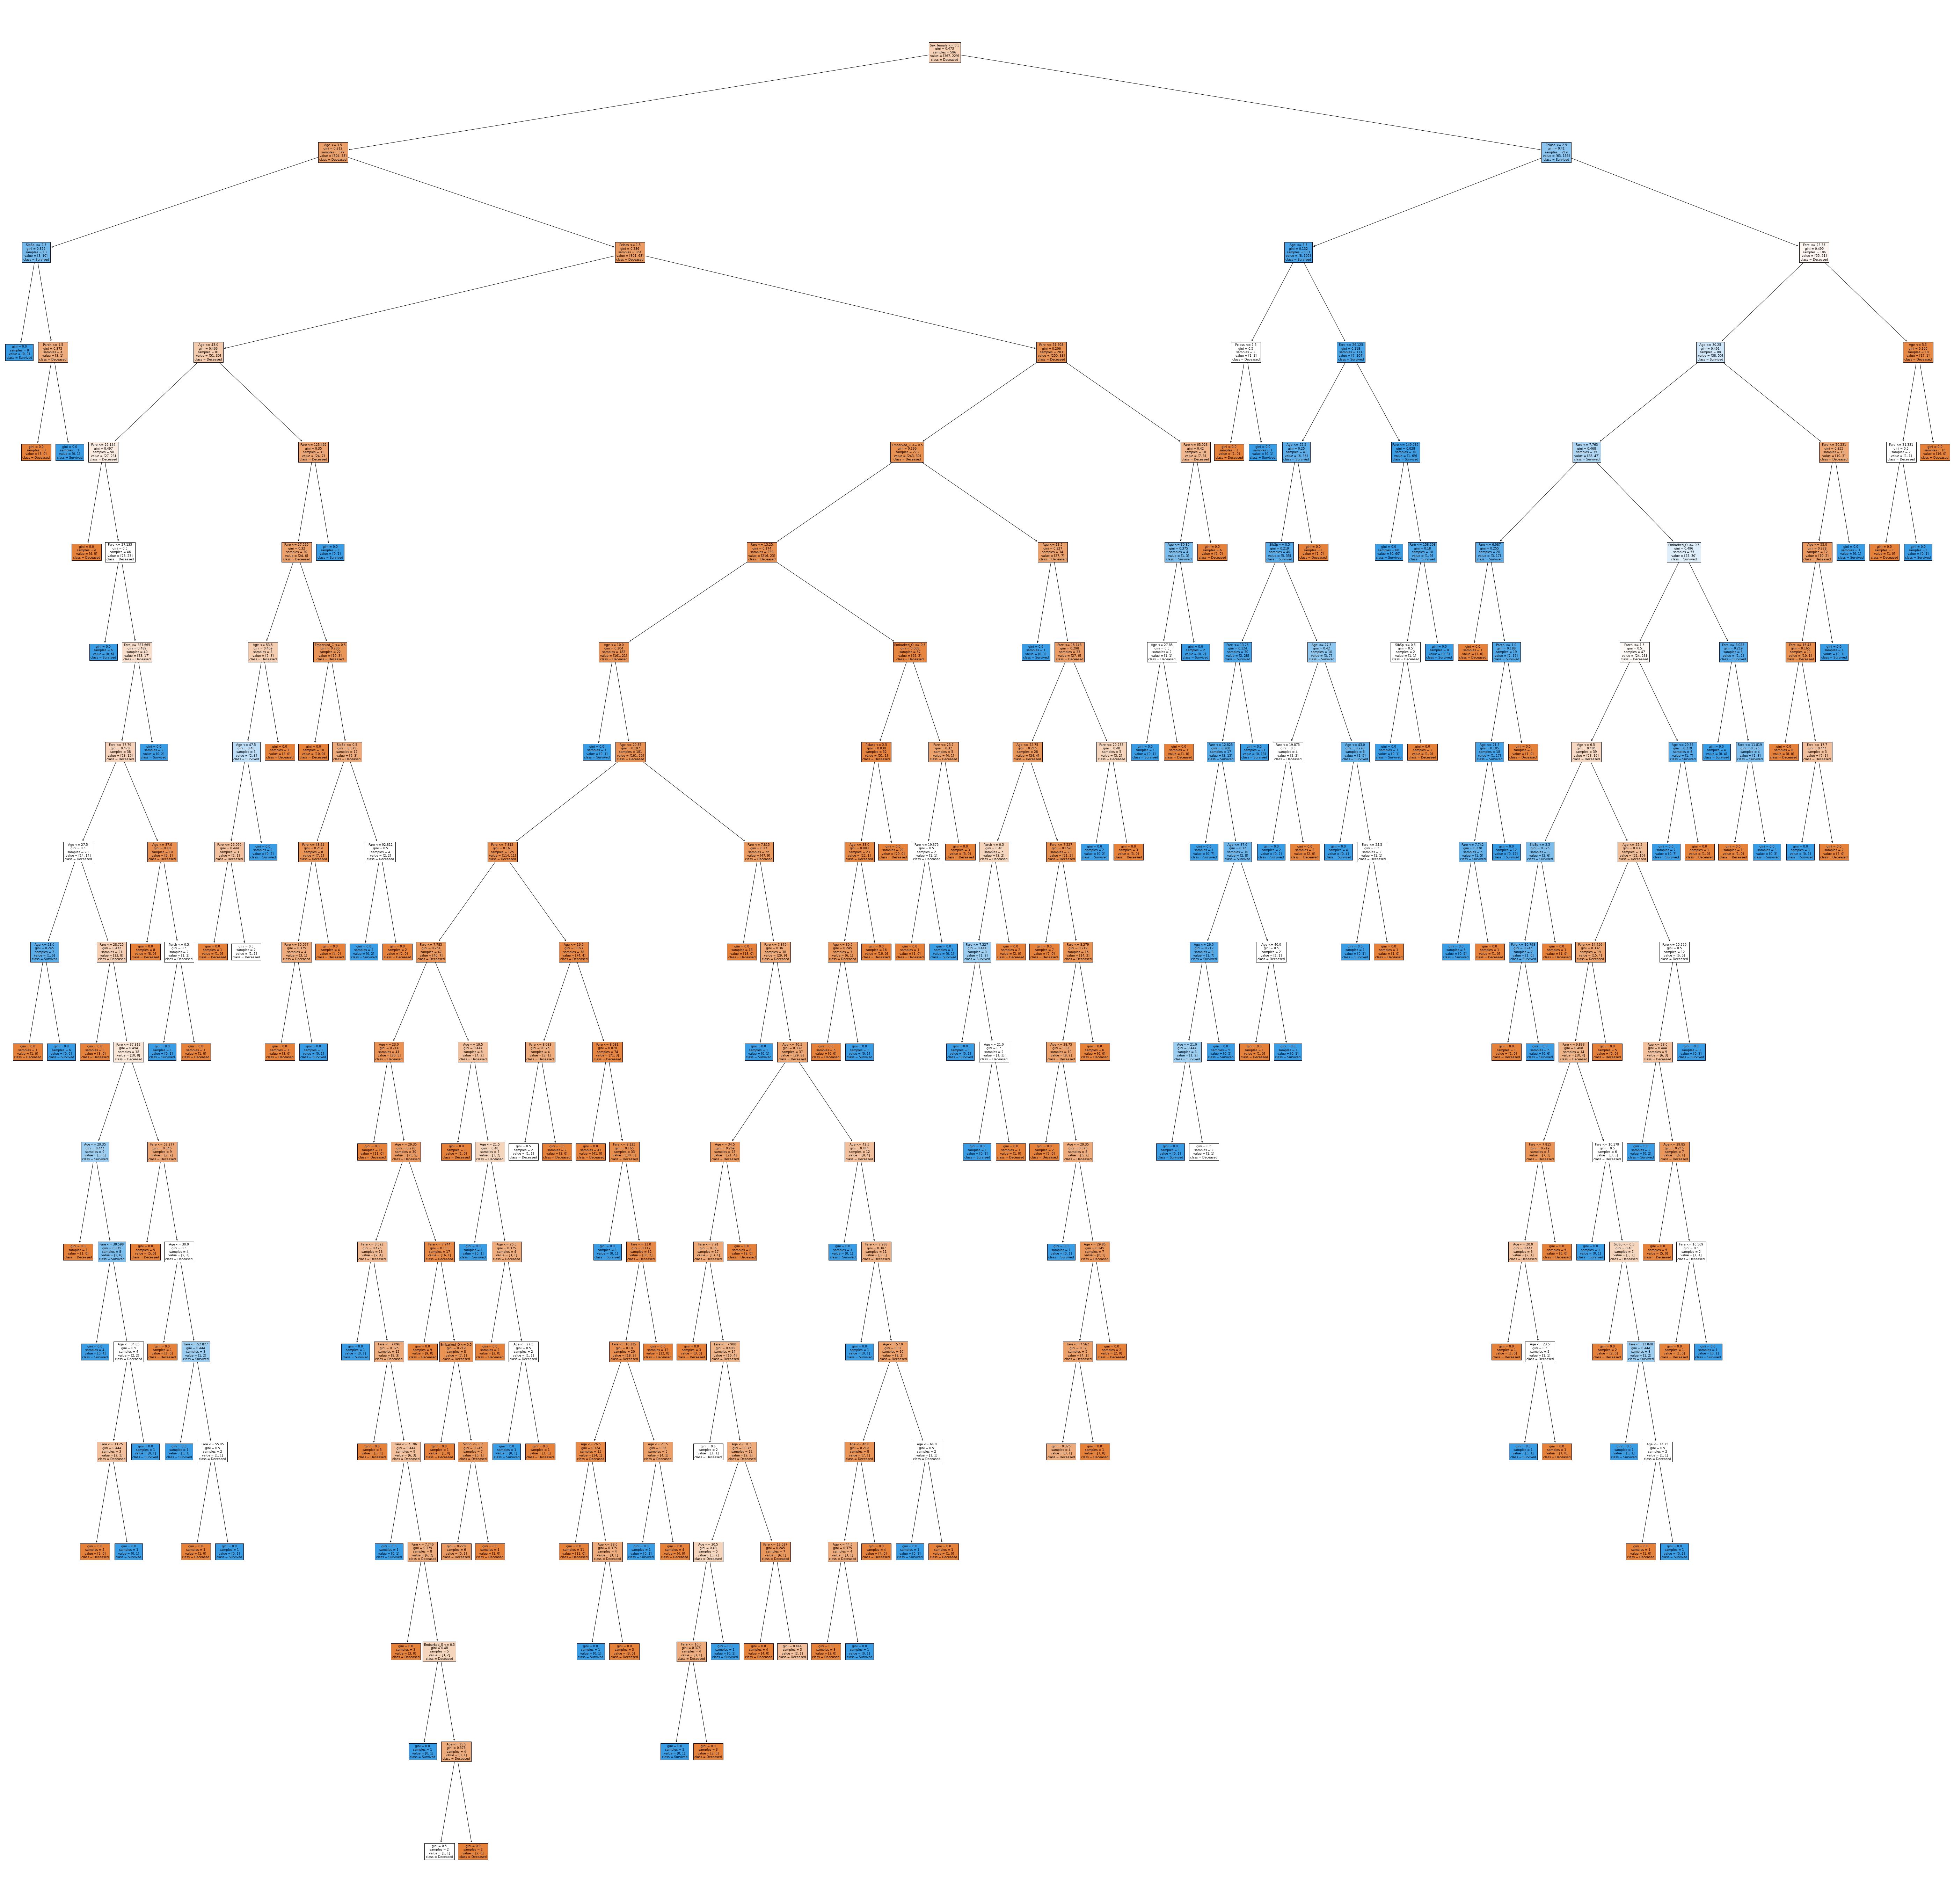

|--- Sex_female <= 0.50
|   |--- Age <= 3.50
|   |   |--- SibSp <= 2.50
|   |   |   |--- class: 1
|   |   |--- SibSp >  2.50
|   |   |   |--- Parch <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- Parch >  1.50
|   |   |   |   |--- class: 1
|   |--- Age >  3.50
|   |   |--- Pclass <= 1.50
|   |   |   |--- Age <= 43.00
|   |   |   |   |--- Fare <= 26.14
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Fare >  26.14
|   |   |   |   |   |--- Fare <= 27.14
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Fare >  27.14
|   |   |   |   |   |   |--- Fare <= 387.66
|   |   |   |   |   |   |   |--- Fare <= 77.79
|   |   |   |   |   |   |   |   |--- Age <= 27.50
|   |   |   |   |   |   |   |   |   |--- Age <= 21.00
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- Age >  21.00
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- Age >  27.50
|   |   |   |   |   |   |   |   |   |--- Fare <

In [30]:
####### INSERT YOUR CODE HERE
plt.figure(figsize=(100,100))
plot_tree(titanictree, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()
print(export_text(titanictree, feature_names=list(Xtrain.columns)))

The default classification tree will split the data into more and more nodes until no improvement in impurity can be gained. This is the reason we have obtained a very large tree. But how practical is this tree? Let's measure its performance over the test set. We can do this using the **score** function of the titanictree, following the standard scikit-learn interfaces.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
     Measure the score of the tree over the <b>test set</b>. Do you think it is any good?
 </td></tr>
</table>

In [31]:
####### INSERT YOUR CODE HERE
titanictree.score(Xtest, Ytest)

0.7728813559322034

### Explaining the tree, step by step

The tree we built above was too large for interpretation. Fortunately we can control the size of the tree, by specifying the **max_depth** parameter when we create the DecisionTreeClassifier object. We can exploit this to build smaller trees that have an easier interpretation.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Build a tree with <b>max_depth=1</b>, and train it on the Titanic data. Then print the accuracy of that tree on the test set, and plot the tree as well. Which explanatory variable has been selected for the first (and only) split of the tree? Does this make sense?
 </td></tr>
</table>

Tree accuracy is 0.816949


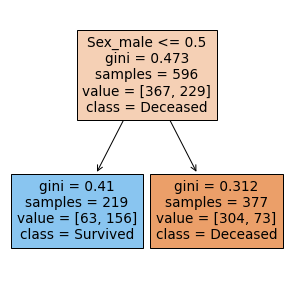

In [32]:
####### INSERT YOUR CODE HERE
smalltree = DecisionTreeClassifier(max_depth=1)
smalltree.fit(Xtrain, Ytrain)
print("Tree accuracy is %f" % smalltree.score(Xtest, Ytest))
plt.figure(figsize=(5,5))
plot_tree(smalltree, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()
# If the gender is not female (is male), there is a smaller chance of survival
# (alternatively, if the gender is not male, there is a larger change of survival)

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Build a tree with <b>max_depth=2</b>, and train it on the Titanic data.  Then print the accuracy of that tree on the test set, and plot the tree as well. Which other features are relevant for explaining the probability of survival of passengers? Do these features make sense?
 </td></tr>
</table>

Tree accuracy is 0.806780


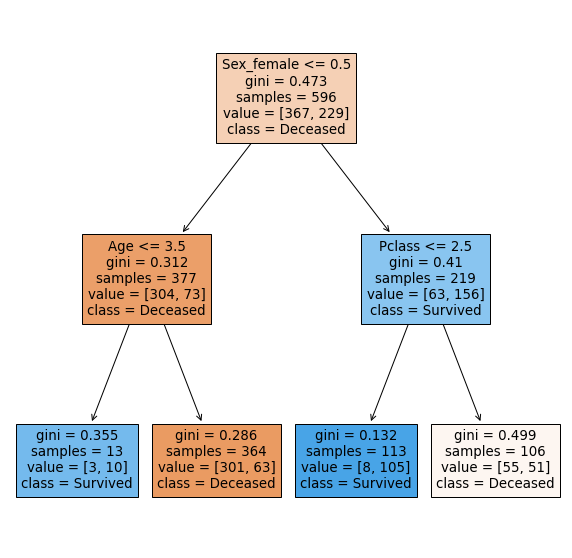

In [33]:
####### INSERT YOUR CODE HERE
smalltree = DecisionTreeClassifier(max_depth=2)
smalltree.fit(Xtrain, Ytrain)
print("Tree accuracy is %f" % smalltree.score(Xtest, Ytest))
plt.figure(figsize=(10,10))
plot_tree(smalltree, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()
# Even if the gender is male, kids (age <= 13.0) are more likely to survive. 
# Also women travelling in third class are not likely to survive

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Build yet another tree with <b>max_depth=3</b>, and train it on the Titanic data.  Then print the accuracy of that tree on the test set, and plot the tree as well. Does any other relevant feature appear? Can you spot any sign of overfitting?
 </td></tr>
</table>

Tree accuracy is 0.840678


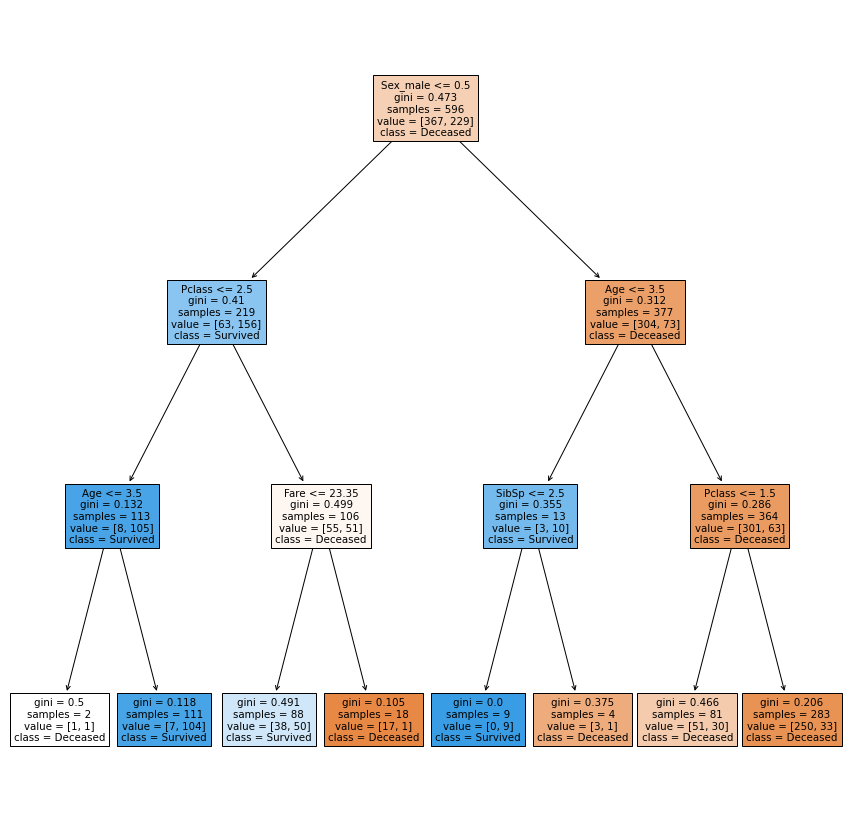

In [34]:
####### INSERT YOUR CODE HERE
smalltree = DecisionTreeClassifier(max_depth=3)
smalltree.fit(Xtrain, Ytrain)
print("Tree accuracy is %f" % smalltree.score(Xtest, Ytest))
plt.figure(figsize=(15,15))
plot_tree(smalltree, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()

## Optimizing the tree parameters

### Pre-pruning the tree

Decision Trees are prone to overfitting, and so we must use some kind of **pruning** to generate trees that have good generalization properties. scikit-learn implements several **pre-pruning** mechanisms, which stop the splitting procedure of the tree after some conditions are met:

* **max_depth**: maximum depth at which the tree can continue creating splits.
* **min_samples_split**: the minimum number of samples required to split an internal node.
* **min_samples_leaf**: the minimum number of samples required for a leaf node. A split point at any depth will only be considered if it generates at least min_samples_leaf training samples in each of the left and right children.
* **min_impurity_decrease**: a node will be split only if the split induces a decrease of the impurity greater than or equal to this value.

(Other alternative pre-pruning strategies are possible: [seed the docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier))

These parameters are usually set through an independent validation set or some kind of cross-validation procedure. Here we will use a cross-validation strategy over the training set to test a range of different pre-pruning strategies. We will do so using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) class:

In [35]:
from sklearn.model_selection import GridSearchCV

This class will take a dictionary of parameters, with the values we want to try for each parameter. For this case, we can use the following:

In [36]:
param_grid = {
    "max_depth": [1, 2, 3, 4],
    "min_samples_split": [ 2, 5, 10, 20],
    "min_samples_leaf": [2, 5, 10, 20],
    "min_impurity_decrease": [1e-3, 1e-2, 1e-1]
}

With this, we can build a GridSearchCV by specifying the model we want to optimize, and the dictionary of parameters to test:

In [37]:
treesearch = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = param_grid,
    n_jobs=-1
)

A GridSearchCV behaves in the same way as any other model in scikit-learn (including a simple tree). We can `fit` it over the training data and then compute its `score` over the test data. However, when using `fit`, the GridSearchCV will estimate the performance of the decision tree for each possible combination of the parameter values we have provided in the dictionary. This estimation is done by running a 5-fold cross validation procedure. Once all possible combinations are tested, the decision tree is trained using the whole training data and the parameters that produced the best score in the cross validation.

All of this is done automatically, but it is expensive, as it requires training a large number of models: 5 for each possible combination of parameters. To accelerate this procedure we can use the `n_jobs` parameter, which tells scikit-learn it can use as many parallel threads for training models. When specifying a value of `-1`, all processors available in your machine are used.

In [38]:
treesearch.fit(Xtrain, Ytrain)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'min_impurity_decrease': [0.001, 0.01, 0.1],
                         'min_samples_leaf': [2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20]})

Once the GridSearchCV is trained, we can check which parameter values were chosen

In [39]:
treesearch.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Now print the accuracy of the best pruned tree over the test set, and also plot such tree. Answer the following questions: is the tree interpretable? Does any non-relevant variable appear in the tree? Do you think some kind of post-pruning strategy could reduce further the size of the tree without damaging performance?
 </td></tr>
</table>

Tree accuracy is 0.827119


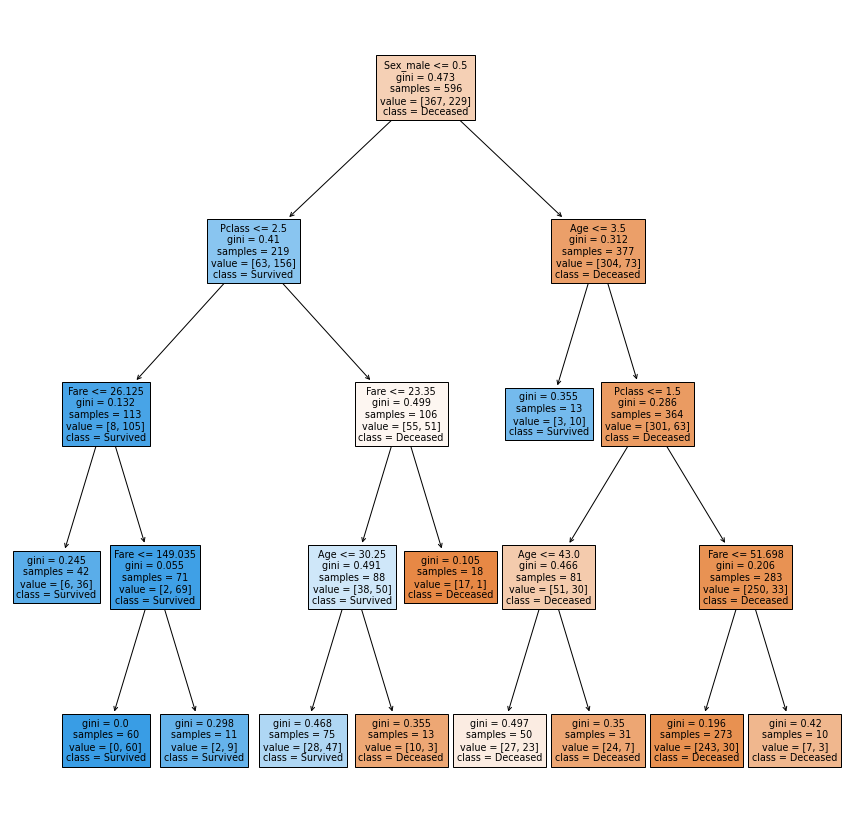

In [40]:
####### INSERT YOUR CODE HERE
print("Tree accuracy is %f" % treesearch.score(Xtest, Ytest))
plt.figure(figsize=(15,15))
plot_tree(treesearch.best_estimator_, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()

### Post-pruning the tree

Another approach to prevent overfitting is to allow the tree to grow maximally during training, then **prune** the parts of the tree that worsen the generalization error. A particularly popular method of doing this is called **Cost-complexity pruning**, and is implemented in the Decision Trees as the **ccp_alpha** ($\alpha$) parameter. For $\alpha=0$ no post-pruning will be performed on the tree. The larger $\alpha$ becomes, the more aggresive pruning we will perform. For example, let's build a tree over the Titanic data with $\alpha=0.02$:

Tree accuracy is 0.803390


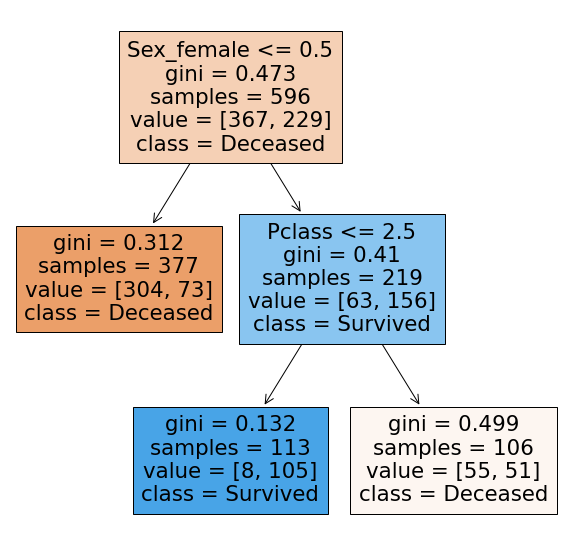

In [41]:
prunedtree = DecisionTreeClassifier(ccp_alpha=0.02)
prunedtree.fit(Xtrain, Ytrain)
print("Tree accuracy is %f" % prunedtree.score(Xtest, Ytest))
plt.figure(figsize=(10,10))
plot_tree(prunedtree, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()

Although we have not limited the tree growth in any way, the post-pruning step produces a smaller tree that is able to perform well on the test data.

An advantage of this pruning strategy is that we can compute the whole **regularization path** for all possible $\alpha$ values. This allows for a model selection strategy different from the usual GridSearchCV, but for which we will need to keep aside a part of the training data as a separate validation dataset.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Create DataFrames <b>Xsubtrain</b>, <b>Ysubtrain</b>, <b>Xval</b> and <b>Yval</b>, containing approximately two thirds and one third of the training data, respectively. Make sure this split is stratified.
 </td></tr>
</table>

<table>
 <tr><td width="80"><img src="img/exclamation.png" style="width:auto;height:auto"></td><td style="text-align:left">
 You can use the train_test_split method for this, as you did before to split between the train and test datasets.
 </td></tr>
</table>

In [42]:
####### INSERT YOUR CODE HERE
Xsubtrain, Xval, Ysubtrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.33, stratify=Ytrain)

Now we can compute the regularization path making use of the **cost_complexity_pruning_path** method. Note how this is a method from DecisionTreeClassifier, but we don't need to fit the tree to use it.

In [43]:
path = DecisionTreeClassifier().cost_complexity_pruning_path(Xsubtrain, Ysubtrain)
path

{'ccp_alphas': array([0.        , 0.00055695, 0.00083542, 0.00083542, 0.0015515 ,
        0.00167084, 0.00167084, 0.00167084, 0.00179909, 0.0018797 ,
        0.00190954, 0.00201894, 0.00208855, 0.00208855, 0.00210286,
        0.00221039, 0.00221387, 0.00222779, 0.00231348, 0.00236703,
        0.00239234, 0.00250021, 0.00262561, 0.00265315, 0.00269741,
        0.00287899, 0.00294508, 0.00300752, 0.0032918 , 0.00334169,
        0.0034491 , 0.00396596, 0.00401003, 0.00442548, 0.00462695,
        0.00483749, 0.00669034, 0.00726519, 0.00802005, 0.01114024,
        0.01411491, 0.01659585, 0.02817152, 0.13895018]),
 'impurities': array([0.00835422, 0.00946811, 0.01030354, 0.01197438, 0.01352588,
        0.01686757, 0.02020925, 0.02689263, 0.03408898, 0.03784838,
        0.03975792, 0.04379579, 0.0479729 , 0.05632712, 0.07945854,
        0.08387931, 0.08830705, 0.09276263, 0.09738958, 0.10212364,
        0.10690833, 0.11190875, 0.11715998, 0.11981313, 0.14678725,
        0.15542423, 0.1613144 

The method returns a dictionary with a list of all the $\alpha$ values at which a branch of the tree is pruned off, as well as a parallel list with the impurities attained by the tree at such level of pruning. As $\alpha$ grows, more pruning is performed, producing a smaller tree with larger impurity. We can confirm this by plotting the values of the regularization path:

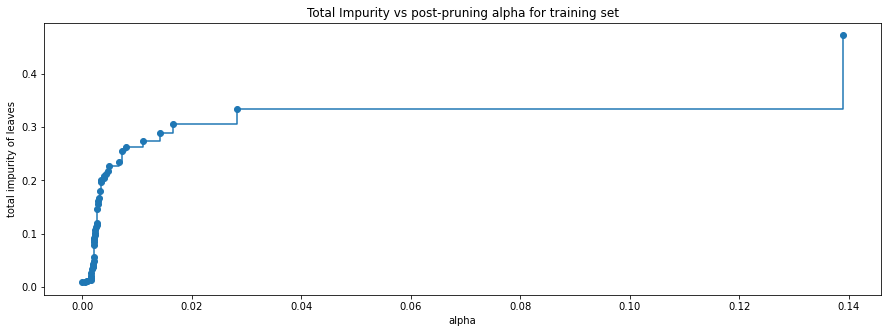

In [44]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(path["ccp_alphas"], path["impurities"], marker='o', drawstyle="steps-post")
ax.set_xlabel("alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs post-pruning alpha for training set")
plt.show()

We will now train a tree for each one of the different $\alpha$ values in the regularization path, thus obtaining all possible pruned trees for this training data.

In [45]:
path_trees = [
    DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha).fit(Xsubtrain, Ysubtrain)
    for ccp_alpha in path["ccp_alphas"]
]

The larger the $\alpha$ value the more aggresive pruning the tree has been subject to. We can check this by creating a plot showing $\alpha$ vs number of tree nodes or tree depth.

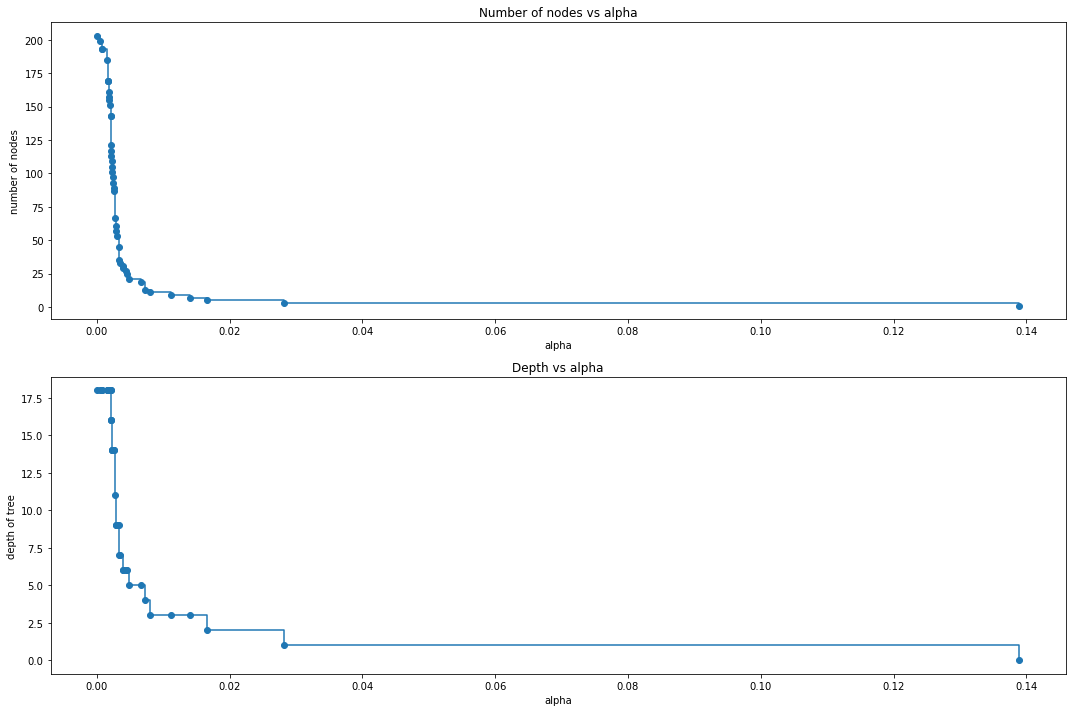

In [46]:
node_counts = [clf.tree_.node_count for clf in path_trees]
depth = [clf.tree_.max_depth for clf in path_trees]
fig, ax = plt.subplots(2, 1, figsize=(15,10))
ax[0].plot(path["ccp_alphas"], node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(path["ccp_alphas"], depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Now, the whole point of keeping a separate validation dataset is to measure the generalization ability of each tree in the regularization path. We can do that as follows, comparing performance in the training subdataset and the validation dataset.

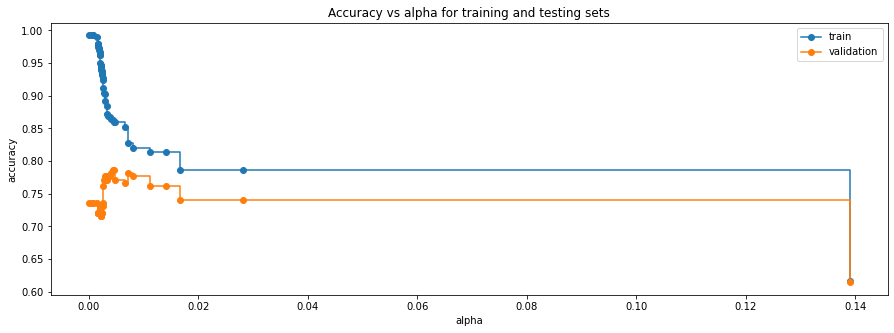

In [47]:
train_performances = [tree.score(Xsubtrain, Ysubtrain) for tree in path_trees]
val_performances = [tree.score(Xval, Yval) for tree in path_trees]

fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(path["ccp_alphas"], train_performances, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(path["ccp_alphas"], val_performances, marker='o', label="validation",
        drawstyle="steps-post")
ax.legend()
plt.show()

As expected, for small $\alpha$ values overfitting happens, resulting in almost perfect accuracy in the training data but poor performance on the validation data. Conversely, if $\alpha$ is too large the performance in both training and validation data is low, as the tree is too small to be a meaningful model: we are suffering underfitting. The best choice for our production model would be the tree with highest validation score.

In [48]:
bestscore_index = np.argmax(val_performances)
besttree = path_trees[bestscore_index]

We can now plot this tree and check its score over the test data

Tree accuracy is 0.823729
DecisionTreeClassifier(ccp_alpha=0.004425478109688644, random_state=0)


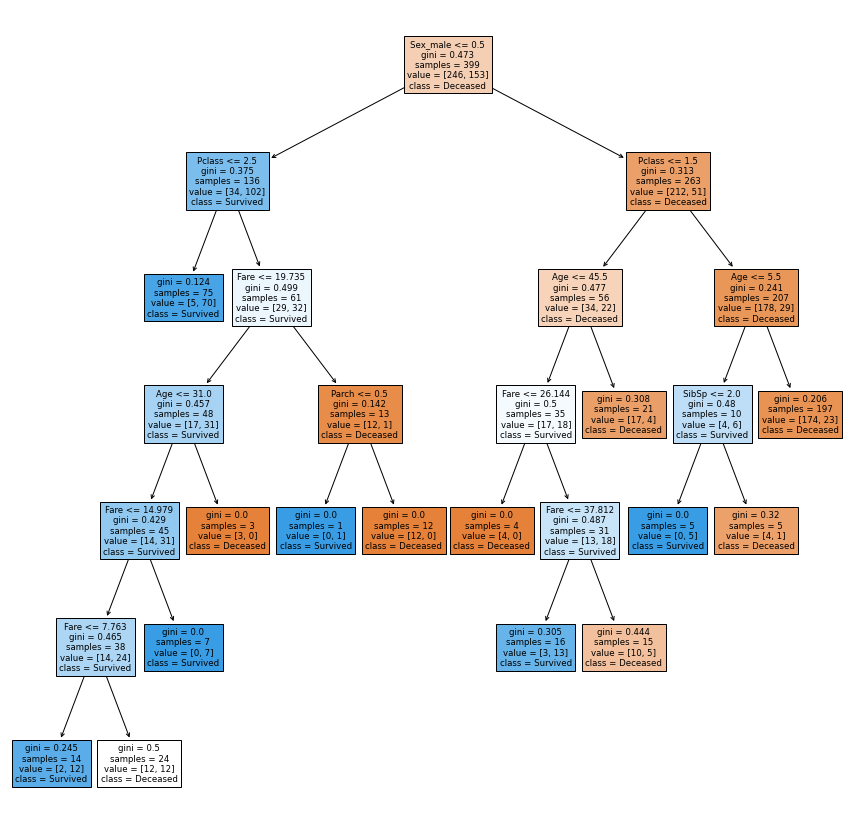

In [49]:
print("Tree accuracy is %f" % besttree.score(Xtest, Ytest))
print(besttree)
plt.figure(figsize=(15,15))
plot_tree(besttree, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()

Note that if the training dataset is small we can still perform the usual GridSearch strategy to avoid sacrificing part of the data as validation data.

<table>
 <tr><td width="80"><img src="img/question.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Run a GridSearchCV crossvalidation to find the best post-pruned tree over the training data, by testing different values for the $\alpha$ parameter. Note regularization parameters such as $\alpha$ are better tuned by selecting values in a logarithmic scale: 0.01, 0.02, 0.05, 0.1, ...
 Once the best tree hast been found, compute its score over the test set and visualize it.
 </td></tr>
</table>

Tree accuracy is 0.833898
DecisionTreeClassifier(ccp_alpha=0.005)


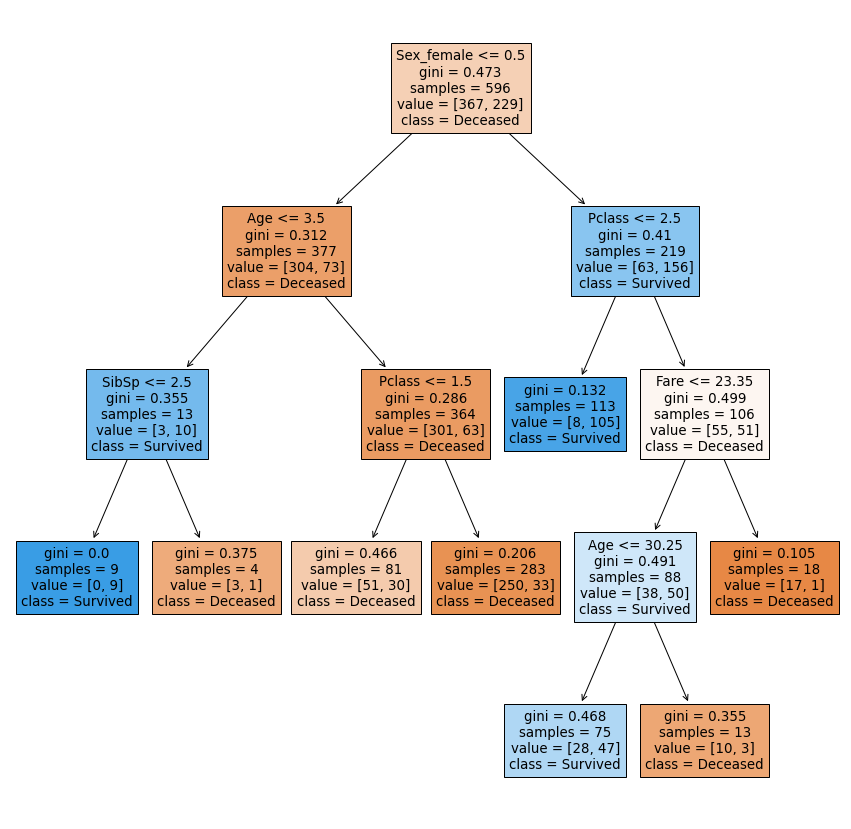

In [50]:
####### INSERT YOUR CODE HERE
param_grid = {
    "ccp_alpha": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
}

besttree = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = param_grid,
    n_jobs=8
)
besttree.fit(Xtrain, Ytrain)

print("Tree accuracy is %f" % besttree.score(Xtest, Ytest))
print(besttree.best_estimator_)
plt.figure(figsize=(15,15))
plot_tree(besttree.best_estimator_, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()

## Bonus round: trying different impurity functions

<table>
 <tr><td width="80"><img src="img/pro.png" style="width:auto;height:auto"></td><td style="text-align:left">
 Repeat the GridSearchCV procedure, either with pre-pruning, post-pruning or both, but now also exploring other impurity functions (check the <a href=http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html>docs</a>). Can you improve on this dataset over using the Gini impurity?
 </td></tr>
</table>

Tree accuracy is 0.833898
DecisionTreeClassifier(ccp_alpha=0.005, criterion='entropy', max_depth=4,
                       min_impurity_decrease=0.001, min_samples_leaf=5)


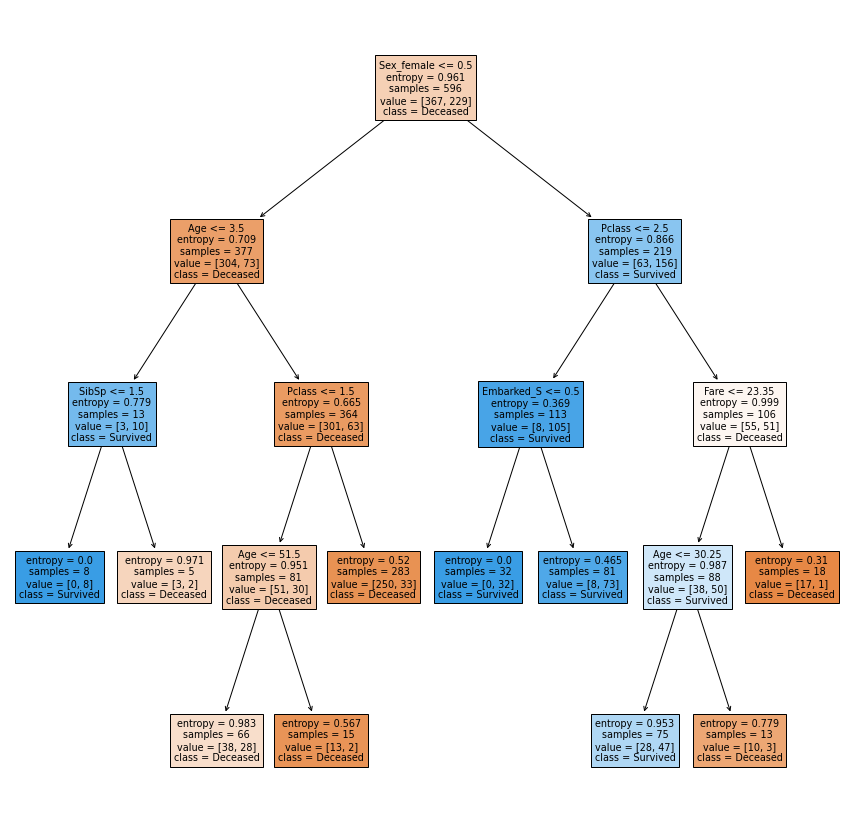

In [51]:
####### INSERT YOUR CODE HERE
param_grid_crit = {
    "criterion" : ["gini", "entropy"],
    "max_depth": [1, 2, 3, 4],
    "min_samples_split": [ 2, 5, 10, 20],
    "min_samples_leaf": [2, 5, 10, 20],
    "min_impurity_decrease": [1e-3, 1e-2, 1e-1],
    "ccp_alpha": [0, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
}

besttree = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = param_grid_crit,
    n_jobs=-1
)
besttree.fit(Xtrain, Ytrain)
print("Tree accuracy is %f" % besttree.score(Xtest, Ytest))
print(besttree.best_estimator_)
plt.figure(figsize=(15,15))
plot_tree(besttree.best_estimator_, feature_names=Xtrain.columns, class_names=["Deceased", "Survived"], filled=True)
plt.show()